In [ ]:
!pip install opencv-python-headless
!pip install foolbox

In [1]:
#@title Imports
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import Dataset, Subset, DataLoader, random_split
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingWarmRestarts

from torchvision import transforms, datasets
from torchvision.datasets import CIFAR10, ImageFolder
import torchvision.transforms.v2 as v2
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

import re

from functools import partial
from typing import List

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.layers.squeeze_excite import EffectiveSEModule
from timm.models import register_model, build_model_with_cfg, named_apply, generate_default_cfgs
from timm.layers import DropPath
from timm.layers import LayerNorm2d
import timm

from torchvision.transforms import InterpolationMode

from sklearn.model_selection import StratifiedShuffleSplit

import ssl

import foolbox as fb

import cv2
import matplotlib.pyplot as plt

import time
import gc

In [2]:
if torch.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(f"Device: {device}")

Device: cuda


In [3]:
seed = 29
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [4]:
DATA_ROOT = './data.cifar10'

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Model Specific Transformations

In [5]:
timm_model = timm.create_model('rdnet_tiny.nv_in1k', pretrained=True)
data_config = timm.data.resolve_model_data_config(timm_model)
transform = timm.data.create_transform(**data_config, is_training=True)
test_transform = timm.data.create_transform(**data_config, is_training=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/95.6M [00:00<?, ?B/s]

### Getting the pretrained weights. Hugging face models use .bin format.

In [6]:
torch.save(timm_model.state_dict(), 'rdnet_tiny_pretrained.pth')

### Reproducing the same transformation locally not relying on timm

In [7]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(
        size=(224, 224),
        scale=(0.08, 1.0),
        ratio=(0.75, 1.3333),
        interpolation=InterpolationMode.BICUBIC
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(
        brightness=(0.6, 1.4),
        contrast=(0.6, 1.4),
        saturation=(0.6, 1.4)
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])


test_transform = transforms.Compose([
    transforms.Resize(
        size=248,
        interpolation=InterpolationMode.BICUBIC,
        antialias=True
    ),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])

### In case there is a ssl certificate issue

In [8]:
ssl._create_default_https_context = ssl._create_unverified_context

### CIFAR 10 DATA DOWNLOAD

In [9]:
trainset = CIFAR10(root=DATA_ROOT, train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = CIFAR10(root=DATA_ROOT, train=False, download=True, transform=test_transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 42.8MB/s]


In [10]:
full_dataset = CIFAR10(root=DATA_ROOT, train=True, download=True)
targets = np.array(full_dataset.targets)

sss = StratifiedShuffleSplit(n_splits=1, test_size=5000, random_state=29)
train_idx, val_idx = next(sss.split(np.zeros(len(targets)), targets))

train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform   = test_transform

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

test_dataset = CIFAR10(root=DATA_ROOT, train=False, download=True, transform=test_transform)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [11]:
#@title RDNet Implementation
__all__ = ["RDNet"]


class RDNetClassifierHead(nn.Module):
    def __init__(
        self,
        in_features: int,
        num_classes: int,
        drop_rate: float = 0.,
    ):
        super().__init__()
        self.in_features = in_features
        self.num_features = in_features

        self.norm = nn.LayerNorm(in_features)
        self.drop = nn.Dropout(drop_rate)
        self.fc = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

    def reset(self, num_classes):
        self.fc = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

    def forward(self, x, pre_logits: bool = False):
        x = x.mean([-2, -1])
        x = self.norm(x)
        x = self.drop(x)
        if pre_logits:
            return x
        x = self.fc(x)
        return x


class PatchifyStem(nn.Module):
    def __init__(self, num_input_channels, num_init_features, patch_size=4):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(num_input_channels, num_init_features, kernel_size=patch_size, stride=patch_size),
            LayerNorm2d(num_init_features),
        )

    def forward(self, x):
        return self.stem(x)


class Block(nn.Module): #this is Feature MIXER
    """D == Dw conv, N == Norm, F == Feed Forward, A == Activation"""
    def __init__(self, in_chs, inter_chs, out_chs):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_chs, in_chs, groups=in_chs, kernel_size=7, stride=1, padding=3),
            LayerNorm2d(in_chs, eps=1e-6),
            nn.Conv2d(in_chs, inter_chs, kernel_size=1, stride=1, padding=0),
            nn.GELU(),
            nn.Conv2d(inter_chs, out_chs, kernel_size=1, stride=1, padding=0),
        )

    def forward(self, x):
        return self.layers(x)


class BlockESE(nn.Module): # this is Feature MIXER
    """D == Dw conv, N == Norm, F == Feed Forward, A == Activation"""
    def __init__(self, in_chs, inter_chs, out_chs):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_chs, in_chs, groups=in_chs, kernel_size=7, stride=1, padding=3),
            LayerNorm2d(in_chs, eps=1e-6),
            nn.Conv2d(in_chs, inter_chs, kernel_size=1, stride=1, padding=0),
            nn.GELU(),
            nn.Conv2d(inter_chs, out_chs, kernel_size=1, stride=1, padding=0),
            EffectiveSEModule(out_chs),
        )

    def forward(self, x):
        return self.layers(x)


class DenseBlock(nn.Module):
    def __init__(
        self,
        num_input_features,
        growth_rate,
        bottleneck_width_ratio, # I think this is wide part of bottleneck
        drop_path_rate,
        drop_rate=0.0,
        rand_gather_step_prob=0.0,
        block_idx=0,
        block_type="Block",
        ls_init_value=1e-6,
        **kwargs,
    ):
        super().__init__()
        self.drop_rate = drop_rate
        self.drop_path_rate = drop_path_rate
        self.rand_gather_step_prob = rand_gather_step_prob
        self.block_idx = block_idx
        self.growth_rate = growth_rate

        self.gamma = nn.Parameter(ls_init_value * torch.ones(growth_rate)) if ls_init_value > 0 else None
        growth_rate = int(growth_rate)
        inter_chs = int(num_input_features * bottleneck_width_ratio / 8) * 8

        if self.drop_path_rate > 0:
            self.drop_path = DropPath(drop_path_rate)

        self.layers = eval(block_type)(
            in_chs=num_input_features,
            inter_chs=inter_chs,
            out_chs=growth_rate, # the concatentation of features
        )

    def forward(self, x):
        if isinstance(x, List):
            x = torch.cat(x, 1)
        x = self.layers(x)

        if self.gamma is not None:
            x = x.mul(self.gamma.reshape(1, -1, 1, 1))

        if self.drop_path_rate > 0 and self.training:
            x = self.drop_path(x)
        return x


class DenseStage(nn.Sequential):
    def __init__(self, num_block, num_input_features, drop_path_rates, growth_rate, **kwargs):
        super().__init__()
        for i in range(num_block):
            layer = DenseBlock(
                num_input_features=num_input_features,
                growth_rate=growth_rate,
                drop_path_rate=drop_path_rates[i],
                block_idx=i,
                **kwargs,
            )
            num_input_features += growth_rate
            self.add_module(f"dense_block{i}", layer)
        self.num_out_features = num_input_features

    def forward(self, init_feature):
        features = [init_feature]
        for module in self:
            new_feature = module(features)
            features.append(new_feature)
        return torch.cat(features, 1)


class RDNet(nn.Module):
    def __init__(
        self,
        num_init_features=64,
        growth_rates=(64, 104, 128, 128, 128, 128, 224),
        num_blocks_list=(3, 3, 3, 3, 3, 3, 3),
        bottleneck_width_ratio=4,
        zero_head=False,
        in_chans=3,  # timm option [--in-chans]
        num_classes=1000,  # timm option [--num-classes]
        drop_rate=0.0,  # timm option [--drop: dropout ratio]
        drop_path_rate=0.0,  # timm option [--drop-path: drop-path ratio]
        checkpoint_path=None,  # timm option [--initial-checkpoint]
        transition_compression_ratio=0.5,
        ls_init_value=1e-6,
        is_downsample_block=(None, True, True, False, False, False, True),
        block_type="Block",
        head_init_scale: float = 1.,
        **kwargs,
    ):
        super().__init__()
        assert len(growth_rates) == len(num_blocks_list) == len(is_downsample_block)

        self.num_classes = num_classes
        if isinstance(block_type, str):
            block_type = [block_type] * len(growth_rates)

        # stem
        self.stem = PatchifyStem(in_chans, num_init_features, patch_size=4)

        # features
        self.feature_info = []
        self.num_stages = len(growth_rates)
        curr_stride = 4  # stem_stride
        num_features = num_init_features
        dp_rates = [x.tolist() for x in torch.linspace(0, drop_path_rate, sum(num_blocks_list)).split(num_blocks_list)]

        dense_stages = []
        for i in range(self.num_stages):
            dense_stage_layers = []
            if i != 0:
                compressed_num_features = int(num_features * transition_compression_ratio / 8) * 8
                k_size = stride = 1
                if is_downsample_block[i]:
                    curr_stride *= 2
                    k_size = stride = 2
                dense_stage_layers.append(LayerNorm2d(num_features))
                dense_stage_layers.append(
                    nn.Conv2d(num_features, compressed_num_features, kernel_size=k_size, stride=stride, padding=0)
                )
                num_features = compressed_num_features

            stage = DenseStage(
                num_block=num_blocks_list[i],
                num_input_features=num_features,
                growth_rate=growth_rates[i],
                bottleneck_width_ratio=bottleneck_width_ratio,
                drop_rate=drop_rate,
                drop_path_rates=dp_rates[i],
                ls_init_value=ls_init_value,
                block_type=block_type[i],
            )
            dense_stage_layers.append(stage)
            num_features += num_blocks_list[i] * growth_rates[i]

            if i + 1 == self.num_stages or (i + 1 != self.num_stages and is_downsample_block[i + 1]):
                self.feature_info += [
                    dict(
                        num_chs=num_features,
                        reduction=curr_stride,
                        module=f'dense_stages.{i}',
                        growth_rate=growth_rates[i],
                    )
                ]
            dense_stages.append(nn.Sequential(*dense_stage_layers))
        self.dense_stages = nn.Sequential(*dense_stages)

        # classifier
        self.head = RDNetClassifierHead(num_features, num_classes, drop_rate=drop_rate)

        # initialize weights
        named_apply(partial(_init_weights, head_init_scale=head_init_scale), self)

        if zero_head:
            nn.init.zeros_(self.head[-1].weight.data)
            if self.head[-1].bias is not None:
                nn.init.zeros_(self.head[-1].bias.data)

        if checkpoint_path is not None:
            self.load_state_dict(torch.load(checkpoint_path, map_location="cpu"))

    @torch.jit.ignore
    def get_classifier(self):
        return self.head.fc

    def reset_classifier(self, num_classes=0, global_pool=None):
        assert global_pool is None
        self.head.reset(num_classes)

    def forward_head(self, x, pre_logits: bool = False):
        return self.head(x, pre_logits=True) if pre_logits else self.head(x)

    def forward_features(self, x):
        x = self.stem(x)
        x = self.dense_stages(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

    def group_matcher(self, coarse=False):
        assert not coarse
        return dict(
            stem=r'^stem',
            blocks=r'^dense_stages\.(\d+)',
        )


def _init_weights(module, name=None, head_init_scale=1.0):
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight)
    elif isinstance(module, nn.BatchNorm2d):
        nn.init.constant_(module.weight, 1)
        nn.init.constant_(module.bias, 0)
    elif isinstance(module, nn.Linear):
        nn.init.constant_(module.bias, 0)
        if name and 'head.' in name:
            module.weight.data.mul_(head_init_scale)
            module.bias.data.mul_(head_init_scale)

### Defining TINY_RDNET Configuration

In [12]:
IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)

rdnet_tiny_cfg = {
    "url": "",  # optional: local path to weights if needed
    "num_classes": 1000,
    "input_size": (3, 224, 224),
    "crop_pct": 0.9,
    "interpolation": "bicubic",
    "mean": IMAGENET_DEFAULT_MEAN,
    "std": IMAGENET_DEFAULT_STD,
    "first_conv": "stem.0",
    "classifier": "head.fc",
}


### RDNet Constructor

In [13]:
def rdnet_tiny(pretrained=False, num_classes=1000, checkpoint_path=None, device="cpu", **kwargs):
    n_layer = 7
    model_args = {
        "num_init_features": 64,
        "growth_rates": [64, 104, 128, 128, 128, 128, 224],
        "num_blocks_list": [3] * n_layer,
        "is_downsample_block": (None, True, True, False, False, False, True),
        "transition_compression_ratio": 0.5,
        "block_type": ["Block", "Block", "BlockESE", "BlockESE", "BlockESE", "BlockESE", "BlockESE"],
        "num_classes": num_classes,
    }

    model = RDNet(**{**model_args, **kwargs})

    if pretrained:
        assert checkpoint_path is not None, "Please provide checkpoint_path for pretrained weights"
        state_dict = torch.load(checkpoint_path, map_location=device, weights_only=False)
        model.load_state_dict(state_dict, strict=False)

    return model

### First Loading the model weights

In [14]:
model = rdnet_tiny(pretrained=True, checkpoint_path="rdnet_tiny_pretrained.pth", device = device)

In [34]:
full_dataset = CIFAR10(root=DATA_ROOT, train=True, download=True)
targets = np.array(full_dataset.targets)

sss = StratifiedShuffleSplit(n_splits=1, test_size=5000, random_state=29)
train_idx, val_idx = next(sss.split(np.zeros(len(targets)), targets))

train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform   = test_transform

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

test_dataset = CIFAR10(root=DATA_ROOT, train=False, download=True, transform=test_transform)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [19]:
# To load the model
path_to_cifar10_weights = "rdnet_tiny_transfer_learn__valLoss0.1992_valAcc93.86.pth"
model = rdnet_tiny(pretrained=False, num_classes=10)
checkpoint = torch.load(path_to_cifar10_weights, map_location=device, weights_only=False)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)

RDNet(
  (stem): PatchifyStem(
    (stem): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((64,), eps=1e-06, elementwise_affine=True)
    )
  )
  (dense_stages): Sequential(
    (0): Sequential(
      (0): DenseStage(
        (dense_block0): DenseBlock(
          (layers): Block(
            (layers): Sequential(
              (0): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=64)
              (1): LayerNorm2d((64,), eps=1e-06, elementwise_affine=True)
              (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
              (3): GELU(approximate='none')
              (4): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
            )
          )
        )
        (dense_block1): DenseBlock(
          (layers): Block(
            (layers): Sequential(
              (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
              (1): LayerNorm2d((128,), eps=1e-06, el

In [29]:
def generate_adversarial_dataset(model, data_loader, device, attack, epsilon=0.03, num_batches=None, save_as_pt=None):
    """
    Generate adversarial examples using Foolbox and return them as a list.
    """
    model.eval().to(device)
    fmodel = fb.PyTorchModel(model, bounds=(0, 1))
    adv_examples = []

    for i, (images, labels) in enumerate(data_loader):
        if num_batches is not None and i >= num_batches:
            break

        images, labels = images.to(device), labels.to(device)
        _, clipped_advs, _ = attack(fmodel, images, labels, epsilons=epsilon)

        for adv_img, label in zip(clipped_advs, labels):
            adv_examples.append((adv_img.detach().cpu(), label.cpu()))

        torch.cuda.empty_cache()

    if save_as_pt:
        torch.save(adv_examples, save_as_pt)
        print(f"Adversarial dataset saved to '{save_as_pt}'")

    return adv_examples

class AdversarialTensorDataset(Dataset):
    """
    Wraps a list of adversarial image-label pairs into a PyTorch Dataset.
    """
    def __init__(self, data):
        self.data = data

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

#fgsm_attack = fb.attacks.FGSM()
fgsm_attack = fb.attacks.L2DeepFoolAttack()

val_transform_no_norm = transforms.Compose([
    transforms.Resize(size=248, interpolation=InterpolationMode.BICUBIC, antialias=True),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor()
])

val_dataset_no_norm_base = CIFAR10(root=DATA_ROOT, train=True, download=True, transform=val_transform_no_norm)
val_dataset_no_norm = Subset(val_dataset_no_norm_base, val_idx)

val_loader_no_norm = DataLoader(val_dataset_no_norm, batch_size=32, shuffle=False, num_workers=2)

adv_data = generate_adversarial_dataset(
    model,
    val_loader_no_norm,
    device,
    fgsm_attack,
    epsilon=0.03,
    num_batches=10,
    save_as_pt="fgsm_adv_dataset.pt"
)

adv_dataset = AdversarialTensorDataset(adv_data)
adv_loader = DataLoader(adv_dataset, batch_size=32, shuffle=True)

Adversarial dataset saved to 'fgsm_adv_dataset.pt'


Fetched one batch of 32 adversarial examples.
Split batch: Group A (16 samples), Group B (16 samples)

Evaluating accuracy on Group A (Adversarial)...
Accuracy on Group A: 50.00%

Applying Gaussian Blur (kernel=(5, 5), sigma=0) to Group B images...
Gaussian blur applied successfully.


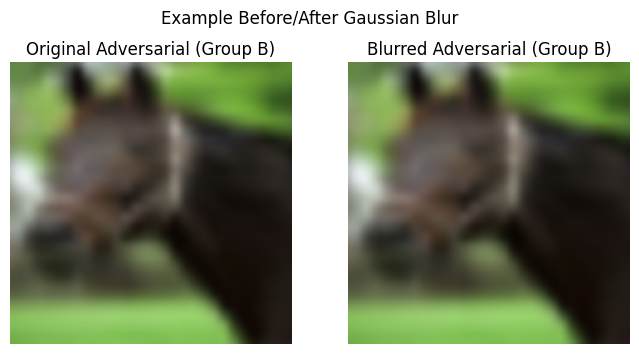


Evaluating accuracy on Group B (Blurred Adversarial)...
Accuracy on Group B (Blurred): 37.50%

--- Comparison ---
Accuracy on Adversarial (Group A):      50.00%
Accuracy on Blurred Adversarial (Group B): 37.50%
Gaussian blur decreased accuracy against these adversarial examples.


In [30]:
GAUSSIAN_KERNEL_SIZE = (5, 5) # Must be odd integers
GAUSSIAN_SIGMA = 0          # If 0, sigma is calculated from kernel size

def evaluate_accuracy(model, data_loader_or_batch, device):
    """Calculates model accuracy on a DataLoader or a single batch."""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        if isinstance(data_loader_or_batch, DataLoader):
             data_iter = data_loader_or_batch
        elif isinstance(data_loader_or_batch, (tuple, list)) and len(data_loader_or_batch) == 2:
             data_iter = [data_loader_or_batch]
        else:
            raise ValueError("Input must be a DataLoader or a tuple/list of (images, labels)")

        for images, labels in data_iter:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    if total == 0:
        return 0.0
    accuracy = 100 * correct / total
    return accuracy

# 1. Get one batch of adversarial data
try:
    images_adv, labels_adv = next(iter(adv_loader))
    print(f"Fetched one batch of {len(images_adv)} adversarial examples.")
except StopIteration:
    print("Adversarial DataLoader is empty. Cannot proceed.")
    exit()
except NameError:
    print("Error: 'adv_loader' not defined. Make sure you ran the previous code cells.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred while fetching data: {e}")
    exit()


# 2. Split the batch into Group A and Group B
batch_size = images_adv.size(0)
if batch_size < 2:
    print("Batch size is too small (< 2) to split. Stopping.")
    exit()

split_idx = batch_size // 2

images_a = images_adv[:split_idx]
labels_a = labels_adv[:split_idx]

images_b = images_adv[split_idx:]
labels_b = labels_adv[split_idx:]

print(f"Split batch: Group A ({len(images_a)} samples), Group B ({len(images_b)} samples)")

# 3. Evaluate accuracy on Group A (original adversarial)
print("\nEvaluating accuracy on Group A (Adversarial)...")
try:
    accuracy_a = evaluate_accuracy(model, (images_a, labels_a), device)
    print(f"Accuracy on Group A: {accuracy_a:.2f}%")
except NameError:
     print("Error: 'model' or 'device' not defined.")
     exit()
except Exception as e:
    print(f"An error occurred during Group A evaluation: {e}")
    exit()


# 4. Apply Gaussian Blur to Group B images
print(f"\nApplying Gaussian Blur (kernel={GAUSSIAN_KERNEL_SIZE}, sigma={GAUSSIAN_SIGMA}) to Group B images...")
images_b_blurred_list = []
for img_tensor in images_b:
    # Convert PyTorch tensor to NumPy array and ensure it's float32
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy().astype(np.float32)

    # Apply Gaussian Blur using OpenCV
    img_blurred_np = cv2.GaussianBlur(img_np, GAUSSIAN_KERNEL_SIZE, GAUSSIAN_SIGMA)

    # Handle potential clipping if blur pushes values outside [0, 1] slightly
    img_blurred_np = np.clip(img_blurred_np, 0, 1)

    # Add channel dimension back if it was squeezed by cv2 (for grayscale)
    if img_blurred_np.ndim == 2:
        img_blurred_np = np.expand_dims(img_blurred_np, axis=-1)

    # Convert back to PyTorch tensor (C, H, W)
    img_blurred_tensor = torch.from_numpy(img_blurred_np).permute(2, 0, 1)
    images_b_blurred_list.append(img_blurred_tensor)

# Stack the list of blurred tensors back into a single batch tensor
if images_b_blurred_list:
    images_b_blurred = torch.stack(images_b_blurred_list)
    print("Gaussian blur applied successfully.")

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(images_b[0].permute(1, 2, 0).cpu().numpy())
    plt.title("Original Adversarial (Group B)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(images_b_blurred[0].permute(1, 2, 0).cpu().numpy())
    plt.title("Blurred Adversarial (Group B)")
    plt.axis('off')
    plt.suptitle("Example Before/After Gaussian Blur")
    plt.show()

    # 5. Evaluate accuracy on Group B (blurred adversarial)
    print("\nEvaluating accuracy on Group B (Blurred Adversarial)...")
    try:
        accuracy_b = evaluate_accuracy(model, (images_b_blurred, labels_b), device)
        print(f"Accuracy on Group B (Blurred): {accuracy_b:.2f}%")

        # 6. Compare Accuracies
        print("\n--- Comparison ---")
        print(f"Accuracy on Adversarial (Group A):      {accuracy_a:.2f}%")
        print(f"Accuracy on Blurred Adversarial (Group B): {accuracy_b:.2f}%")
        if accuracy_b > accuracy_a:
             print("Gaussian blur improved accuracy against these adversarial examples.")
        elif accuracy_b < accuracy_a:
             print("Gaussian blur decreased accuracy against these adversarial examples.")
        else:
             print("Gaussian blur had no significant effect on accuracy for these adversarial examples.")

    except NameError:
        print("Error: 'model' or 'device' not defined.")
    except Exception as e:
        print(f"An error occurred during Group B evaluation: {e}")

else:
    print("Group B was empty after splitting, cannot apply blur or evaluate.")


--- Running 10 Evaluation Runs on NEW Random Batches ---
Applying Gaussian Blur (kernel=(5, 5), sigma=0) to Group B of each batch.
Prerequisites (model, device, adv_loader, evaluate_accuracy) found.
Assuming 'adv_loader' was created with shuffle=True for random batch selection.

--- Processing Run 1/10 ---
Fetched batch 1 with 32 samples.
  Accuracy on Group A (Adversarial): 31.25%
  Accuracy on Group B (Blurred): 25.00%
  Run 1 completed in 0.5360s

--- Processing Run 2/10 ---
Fetched batch 2 with 32 samples.
  Accuracy on Group A (Adversarial): 50.00%
  Accuracy on Group B (Blurred): 43.75%
  Run 2 completed in 0.4452s

--- Processing Run 3/10 ---
Fetched batch 3 with 32 samples.
  Accuracy on Group A (Adversarial): 31.25%
  Accuracy on Group B (Blurred): 62.50%
  Run 3 completed in 0.5416s

--- Processing Run 4/10 ---
Fetched batch 4 with 32 samples.
  Accuracy on Group A (Adversarial): 68.75%
  Accuracy on Group B (Blurred): 31.25%
  Run 4 completed in 1.0434s

--- Processing Run 

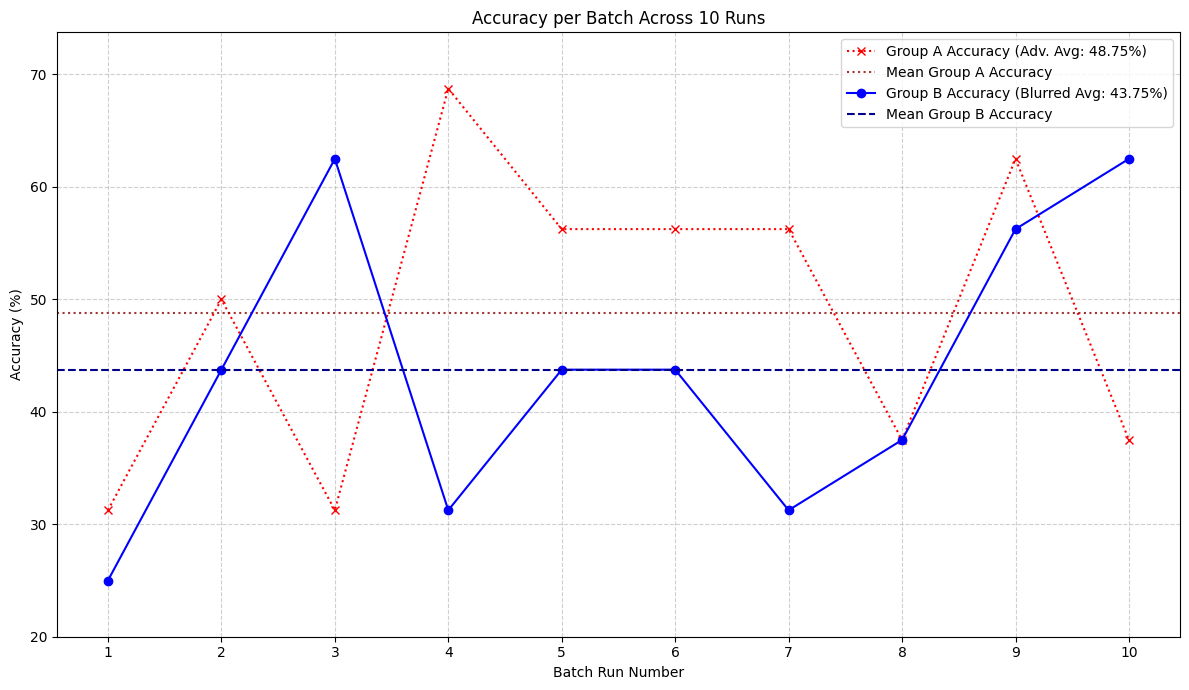

In [36]:
NUM_EVAL_RUNS = 10
GAUSSIAN_KERNEL_SIZE = (5, 5) # Must be odd integers
GAUSSIAN_SIGMA = 0          # If 0, sigma is calculated from kernel size

print(f"\n--- Running {NUM_EVAL_RUNS} Evaluation Runs on NEW Random Batches ---")
print(f"Applying Gaussian Blur (kernel={GAUSSIAN_KERNEL_SIZE}, sigma={GAUSSIAN_SIGMA}) to Group B of each batch.")

try:
    _ = model
    _ = device
    _ = adv_loader
    _ = evaluate_accuracy
    if not isinstance(adv_loader, DataLoader):
         raise NameError("'adv_loader' is not a PyTorch DataLoader")
    print("Prerequisites (model, device, adv_loader, evaluate_accuracy) found.")
    print("Assuming 'adv_loader' was created with shuffle=True for random batch selection.")

except NameError as e:
    print(f"Error: A required variable or function is not defined: {e}")
    print("Please ensure the previous code cells defining these have been run successfully.")
    raise e


# Perform Multiple Evaluation Runs on Different Batches
accuracies_a_runs = [] # Store Group A accuracy for each batch
accuracies_b_runs = [] # Store Group B accuracy for each batch
run_times = []
batches_processed = 0

# Create a single iterator for the loader before the loop
try:
    adv_iterator = iter(adv_loader)

    for i in range(NUM_EVAL_RUNS):
        print(f"\n--- Processing Run {i+1}/{NUM_EVAL_RUNS} ---")
        start_time = time.time()

        # 1. Get a new batch of adversarial data
        try:
            images_adv, labels_adv = next(adv_iterator)
            print(f"Fetched batch {i+1} with {len(images_adv)} samples.")
            batches_processed += 1
        except StopIteration:
            print(f"\nAdversarial DataLoader exhausted after {batches_processed} batches. Stopping early.")
            NUM_EVAL_RUNS = batches_processed
            break

        # 2. Split the current batch into Group A and Group B
        batch_size = images_adv.size(0)
        if batch_size < 2:
            print(f"Batch size ({batch_size}) is too small to split. Skipping run {i+1}.")
            continue

        split_idx = batch_size // 2
        images_a = images_adv[:split_idx]
        labels_a = labels_adv[:split_idx]
        images_b = images_adv[split_idx:]
        labels_b = labels_adv[split_idx:]

        # 3. Evaluate accuracy on Group A (original adversarial) for this batch
        try:
            current_accuracy_a = evaluate_accuracy(model, (images_a, labels_a), device)
            accuracies_a_runs.append(current_accuracy_a)
            print(f"  Accuracy on Group A (Adversarial): {current_accuracy_a:.2f}%")
        except Exception as e:
            print(f"An error occurred during Group A evaluation for run {i+1}: {e}")
            continue

        # 4. Apply Gaussian Blur to Group B images for this batch
        images_b_blurred_list = []
        try:
            for img_tensor in images_b:
                img_np = img_tensor.permute(1, 2, 0).cpu().numpy().astype(np.float32)
                img_blurred_np = cv2.GaussianBlur(img_np, GAUSSIAN_KERNEL_SIZE, GAUSSIAN_SIGMA)
                img_blurred_np = np.clip(img_blurred_np, 0, 1)
                if img_blurred_np.ndim == 2: img_blurred_np = np.expand_dims(img_blurred_np, axis=-1)
                img_blurred_tensor = torch.from_numpy(img_blurred_np).permute(2, 0, 1)
                images_b_blurred_list.append(img_blurred_tensor)

            if not images_b_blurred_list:
                 print("  Group B is empty after split. Skipping blur/eval for Group B.")
                 accuracies_b_runs.append(np.nan)
                 continue

            images_b_blurred = torch.stack(images_b_blurred_list)

            # 5. Evaluate accuracy on Group B (blurred adversarial) for this batch
            current_accuracy_b = evaluate_accuracy(model, (images_b_blurred, labels_b), device)
            accuracies_b_runs.append(current_accuracy_b)
            print(f"  Accuracy on Group B (Blurred): {current_accuracy_b:.2f}%")

        except Exception as e:
             print(f"An error occurred during Group B processing/evaluation for run {i+1}: {e}")
             accuracies_b_runs.append(np.nan)
             continue

        # Memory cleanup
        del images_adv, labels_adv, images_a, labels_a, images_b, labels_b
        if 'images_b_blurred' in locals(): del images_b_blurred
        gc.collect()
        torch.cuda.empty_cache()

        end_time = time.time()
        run_times.append(end_time - start_time)
        print(f"  Run {i+1} completed in {run_times[-1]:.4f}s")


except NameError as e:
     print(f"Error initializing: Required variable '{e.name}' not defined.")
     raise e
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    raise e


# Calculate Statistics
print("\n--- Overall Statistics Across Processed Batches ---")

if batches_processed > 0 and accuracies_b_runs:
    valid_accuracies_a = [acc for acc in accuracies_a_runs if not np.isnan(acc)]
    valid_accuracies_b = [acc for acc in accuracies_b_runs if not np.isnan(acc)]
    num_valid_runs = len(valid_accuracies_b)

    if num_valid_runs > 0:
        accuracies_a_np = np.array(valid_accuracies_a)
        accuracies_b_np = np.array(valid_accuracies_b)

        mean_accuracy_a = np.mean(accuracies_a_np)
        std_dev_accuracy_a = np.std(accuracies_a_np)
        mean_accuracy_b = np.mean(accuracies_b_np)
        std_dev_accuracy_b = np.std(accuracies_b_np)

        print(f"Number of Batches Successfully Processed: {num_valid_runs} (out of {NUM_EVAL_RUNS} requested)")

        print("\nGroup A (Adversarial):")
        print(f"  Average Accuracy:    {mean_accuracy_a:.2f}%")
        print(f"  Standard Deviation:  {std_dev_accuracy_a:.4f}")
        print(f"  Min/Max Accuracy:    {np.min(accuracies_a_np):.2f}% / {np.max(accuracies_a_np):.2f}%")

        print("\nGroup B (Blurred Adversarial):")
        print(f"  Average Accuracy:    {mean_accuracy_b:.2f}%")
        print(f"  Standard Deviation:  {std_dev_accuracy_b:.4f}")
        print(f"  Min/Max Accuracy:    {np.min(accuracies_b_np):.2f}% / {np.max(accuracies_b_np):.2f}%")

        print(f"\nAverage Processing Time per Batch: {np.mean(run_times):.4f}s")

        plt.figure(figsize=(12, 7))

        run_indices = range(1, num_valid_runs + 1)

        # Plot Group A accuracies
        plt.plot(run_indices, accuracies_a_np, marker='x', linestyle=':', color='red', label=f'Group A Accuracy (Adv. Avg: {mean_accuracy_a:.2f}%)')
        plt.axhline(mean_accuracy_a, color='darkred', linestyle=':', alpha=0.8, label='Mean Group A Accuracy')

        # Plot Group B accuracies
        plt.plot(run_indices, accuracies_b_np, marker='o', linestyle='-', color='blue', label=f'Group B Accuracy (Blurred Avg: {mean_accuracy_b:.2f}%)')
        plt.axhline(mean_accuracy_b, color='darkblue', linestyle='--', label='Mean Group B Accuracy')

        plt.title(f'Accuracy per Batch Across {num_valid_runs} Runs')
        plt.xlabel('Batch Run Number')
        plt.ylabel('Accuracy (%)')
        # Calculate reasonable y-limits based on data
        all_accs = np.concatenate((accuracies_a_np, accuracies_b_np))
        min_plot_acc = max(0, np.min(all_accs) - 5)
        max_plot_acc = min(100, np.max(all_accs) + 5)
        plt.ylim(min_plot_acc, max_plot_acc)

        if num_valid_runs <= 20:
             plt.xticks(run_indices)
        else:
             tick_indices = np.linspace(1, num_valid_runs, num=min(num_valid_runs, 10), dtype=int)
             plt.xticks(tick_indices)


        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    else:
        print("No batches were successfully processed completely (check for errors during runs).")

else:
    print("No batches were processed. Cannot calculate statistics or plot.")
    if not adv_loader: print("Check if 'adv_loader' was properly initialized.")